<a href="https://colab.research.google.com/github/Katanov/DA_projects/blob/main/TestovoeAB_OK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тестовое задание: результат A/B-теста


#### Загрузка и предобработка данных

In [1]:
import pandas as pd

In [2]:
df = pd.read_excel('/content/AB_Test_Results.xlsx')

In [118]:
df.head(10)

,user_id,variant_name,revenue
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [5]:
df.columns = df.columns.str.lower()

In [35]:
df.revenue.describe()

count    10000.000000
mean         0.099447
std          2.318529
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        196.010000
Name: revenue, dtype: float64

In [37]:
len(df.query('revenue > 0'))

152

In [38]:
len(df)

10000

Проверим, есть ли пересечения тестовой и контрольной группы:

In [7]:
df.groupby('user_id')['variant_name'].nunique()

user_id
2        1
3        2
4        1
5        1
6        1
        ..
9993     1
9995     1
9996     2
9998     1
10000    2
Name: variant_name, Length: 6324, dtype: int64

In [8]:
df.query('user_id == 3')

,user_id,variant_name,revenue
4145,3,variant,0.0
5377,3,control,0.0
7409,3,variant,0.0


In [119]:
df.groupby('user_id')['variant_name'].nunique().reset_index().head()

,user_id,variant_name
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1


In [11]:
len(df.groupby('user_id')['variant_name'].nunique().reset_index().query('variant_name == 1'))

4783

In [13]:
good_users = df.groupby('user_id')['variant_name'].nunique().reset_index().query('variant_name == 1')

In [14]:
good_users

,user_id,variant_name
0,2,1
2,4,1
3,5,1
4,6,1
5,9,1
...,...,...
6317,9990,1
6318,9992,1
6319,9993,1
6320,9995,1


In [87]:
test = df.query('user_id in @good_users.user_id')

Избавились от пользователей, которые попали в обе группы.

In [16]:
test.groupby('variant_name')['user_id'].count()

variant_name
control    3026
variant    3044
Name: user_id, dtype: int64

Группы примерно равны, это хорошо.

Далее поищем выбросы:

In [44]:
test.groupby('variant_name')['revenue'].mean().reset_index()

,variant_name,revenue
0,control,0.006037
1,variant,0.005739


In [29]:
test.revenue.describe()

count    6070.000000
mean        0.107064
std         2.673501
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       196.010000
Name: revenue, dtype: float64

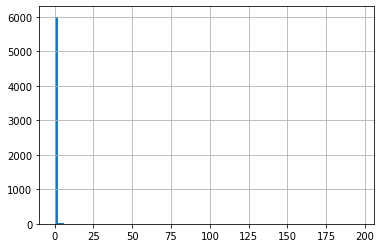

In [28]:
test.revenue.hist(bins=100)

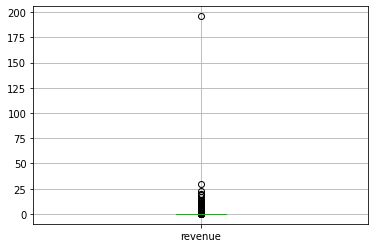

In [31]:
test.boxplot('revenue')

In [120]:
test_clear = test[test.revenue < test.revenue.quantile(q=0.99)]

Выбросы есть, и они крайне существенны. Но благо их не так много, поэтому можно от них смело избавиться.

Впрочем, для чистоты эксперимента можно провести тесты и по данным с выбросами, и по очищенным данным. 

#### Тест Манна — Уитни

In [19]:
import scipy.stats as stats

In [95]:
sampleA = test.query('variant_name == "control"')
sampleB = test.query('variant_name == "variant"')

sampleA = sampleA['revenue']
sampleB = sampleB['revenue']

In [96]:
test.groupby('variant_name')['revenue'].agg(['count','mean']).reset_index()

,variant_name,count,mean
0,control,3026,0.155506
1,variant,3044,0.058909


- Нулевая гипотеза: revenue пользователей в обоих группах равны
- Альтернативная гипотеза: revenue в контрольных группах различаются

α = 0.05

Различия могут быть в обе стороны, поэтому берем двусторонний непараметрический тест Манна-Уитни

In [121]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative='two-sided')[1]))

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

0.248
-0.208


p-value = 0.248, а значит нулевую гипотезу не отвергаем

и посмотрим тоже самое, но уже по данным без явных выбросов:

In [122]:
sampleA = test_clear.query('variant_name == "control"')
sampleB = test_clear.query('variant_name == "variant"')

sampleA = sampleA['revenue']
sampleB = sampleB['revenue']

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative='two-sided')[1]))

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

0.844
-0.049


Здесь p-value уже 0.844, поэтому НЕ отвергаем нулевую гипотезу с еще большей уверенностью :)

Проверим не только по revenue, но и по самому факту покупки, то бишь по конверсии в покупку. Где 0 = покупка не была совершена, а 1 = покупка была совершена.

In [123]:
test['buyer'] = (test['revenue'] > 0)*1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [124]:
test.groupby('variant_name')['buyer'].agg(['count','mean']).reset_index()

,variant_name,count,mean
0,control,3026,0.017845
1,variant,3044,0.014126


In [125]:
sampleA = test.query('variant_name == "control"')
sampleB = test.query('variant_name == "variant"')

sampleA = sampleA['buyer']
sampleB = sampleB['buyer']

In [126]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative='two-sided')[1]))

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

0.248
-0.208


Результат не изменился.

In [127]:
sampleA = test_clear.query('variant_name == "control"')
sampleB = test_clear.query('variant_name == "variant"')

sampleA = sampleA['buyer']
sampleB = sampleB['buyer']

In [128]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative='two-sided')[1]))

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

0.844
-0.064


P-value тот же, что и в случае с revenue по очищенным данным.

#### TTest

Протестим наши группы и на параметрическом тесте, ради эксперимента :)

In [99]:
from scipy.stats import ttest_ind

Данные с выбросами по revenue:

In [130]:
sampleA = test.query('variant_name == "control"')
sampleB = test.query('variant_name == "variant"')

sampleA = sampleA['revenue']
sampleB = sampleB['revenue']

In [131]:
ttest_ind(sampleA, sampleB)[1]

0.15930224976746452

Данные с выбросами по факту покупки:

In [132]:
sampleA = test.query('variant_name == "control"')
sampleB = test.query('variant_name == "variant"')

sampleA = sampleA['buyer']
sampleB = sampleB['buyer']

In [133]:
ttest_ind(sampleA, sampleB)[1]

0.2480143210498805

В обоих случаях p-value выше порогового значения, поэтому нулевую гипотезу не отвергаем.

Чистые данные по revenue:

In [134]:
sampleA = test_clear.query('variant_name == "control"')
sampleB = test_clear.query('variant_name == "variant"')

sampleA = sampleA['revenue']
sampleB = sampleB['revenue']

In [135]:
ttest_ind(sampleA, sampleB)[1]

0.8982144823940894

Чистые данные по факту покупки:

In [136]:
sampleA = test_clear.query('variant_name == "control"')
sampleB = test_clear.query('variant_name == "variant"')

sampleA = sampleA['buyer']
sampleB = sampleB['buyer']

In [137]:
ttest_ind(sampleA, sampleB)[1]

0.8437187117154676

В очищенных данных p-value существенно выше, поэтому нулевая гипотеза не отвергается.

#### БУТСТРЭПИНГ

Данных немного, можно и побутстрэпить немножко.

In [112]:
from tqdm.notebook import tqdm
import numpy as np

In [113]:
group_size = test['variant_name'].value_counts().values

In [114]:
group_size

array([3044, 3026])

In [142]:
test.groupby('variant_name')['buyer'].agg(['count','mean']).reset_index()

,variant_name,count,mean
0,control,3026,0.017845
1,variant,3044,0.014126


In [115]:
n = 1000
result = []
base_diff = 0.017845 - 	0.014126

for _ in tqdm(range(n)):
  a = test.sample(group_size[0],replace=True)['buyer'].mean()
  b = test.sample(group_size[1],replace=True)['buyer'].mean()
  result.append(np.abs(a-b) >= base_diff)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [116]:
np.mean(result)

0.256

In [138]:
group_size = test_clear['variant_name'].value_counts().values

In [139]:
group_size

array([3018, 2990])

In [143]:
test_clear.groupby('variant_name')['buyer'].agg(['count','mean']).reset_index()

,variant_name,count,mean
0,control,2990,0.006020
1,variant,3018,0.005633


In [145]:
n = 1000
result = []
base_diff = 0.006020 - 0.005633

for _ in tqdm(range(n)):
  a = test_clear.sample(group_size[0],replace=True)['buyer'].mean()
  b = test_clear.sample(group_size[1],replace=True)['buyer'].mean()
  result.append(np.abs(a-b) >= base_diff)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [146]:
np.mean(result)

0.804

Видим, что значение p-value не сильно отличается от p-value в тесте Манна-Уитни и в TTest. Так что нулевая гипотеза продолжает жить.

### Вывод

- Нашли пересечения групп, которых не должно было быть, и обнуружили существенные выбросы. 
- Скорее всего тест был проведен не правильно.
- Статистических различий между группами не было обнурежено ни по revenue, но по конверсии в покупку ни одним из трех тестов (Манна-Уитни, TTest, Bootstrap)